## Eli EEG gel data

Example notebook to test the data that Eli sent me on 2024-09-27 regarding his EEG gel collaboration with the group in Edmonton.

## Import libraries

In [1]:
# Common packages
import numpy as np
import matplotlib.pyplot as plt
import pyxdf
import mne
import sys

## Local packages
sys.path.append('..')
from Functions import import_data
from Functions.eeg_quality_index import EEGQualityIndex

## Magic commands
# - Interactive plots
%matplotlib qt

# - Autoreload packages
%load_ext autoreload
%autoreload 3

## Eyes open

Import data file and visualize EEG data.

Creating RawArray with float64 data, n_channels=16, n_times=31488
    Range : 0 ... 31487 =      0.000 ...   122.996 secs
Ready.
Using matplotlib as 2D backend.


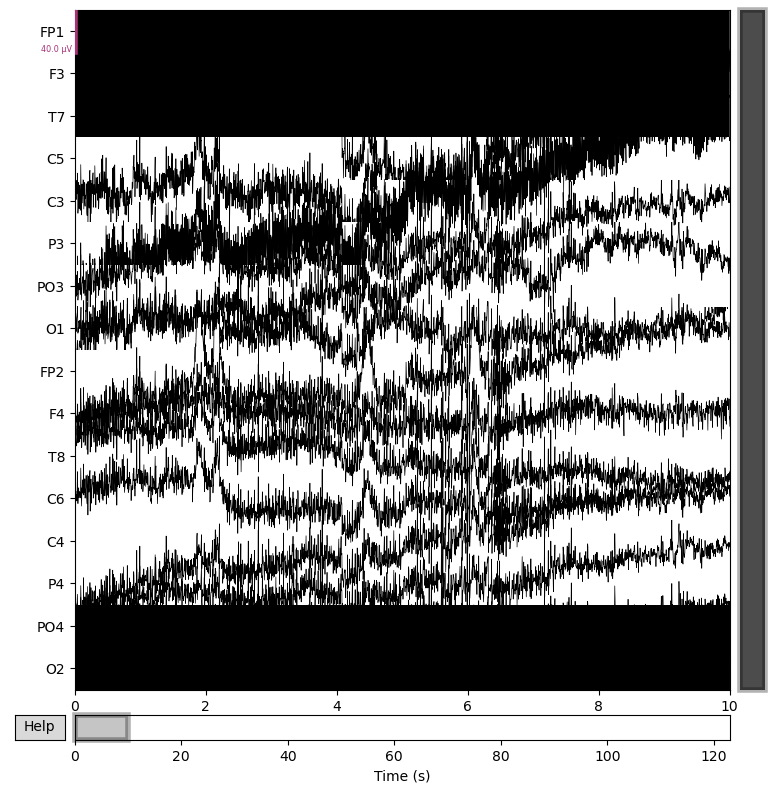

Channels marked as bad: none


In [3]:
eeg_file = r'..\\Data\\Data_Edmonton_Gels_Sept2024\\sub-P001\\ses-S001\\eeg\\sub-P001_ses-S001_task-eyes_open_tension_run-001_eeg.xdf'
mne_data = import_data.xdf_to_mne(eeg_file)
mne_data.plot()

Extract EEG data and compute EEG quality index

In [13]:
test_eeg = mne_data.copy().pick_channels(["F3", "FP1"], True).get_data()[0][np.newaxis,:]

In [12]:
## EEG quality index settings
test_chans = ["F3", "FP1"]
clean_eeg = mne_data.copy().pick_channels(["F3"]).get_data()[0][np.newaxis,:]
test_eeg = mne_data.copy().pick_channels(test_chans, True).get_data()[0]
srate = mne_data.info['sfreq']
sliding = True                  # Sliding window flag
slide_window = int(1 * srate)   # Sliding window size [sec * samples = samples]
slide_step = int(0.5 * srate)   # Sliding window step [sec * samples = samples]            

## Create EEG quality index object
eeg_quality = EEGQualityIndex(
    clean_eeg,
    test_eeg,
    srate,
    sliding = sliding,
    window = slide_window,
    slide = slide_step
    )

## Compute EEG quality index scores
eqi_scores = eeg_quality.scoring()

ValueError: test_eeg must be a 2D array

Visualize EEG quality index

In [6]:
eeg_quality.heatmap(
    chans = test_chans
)

ValueError: Shape of passed values is (6, 2), indices imply (6, 3)

In [4]:
eeg_eyes_open = pyxdf.load_xdf(r'..\\Data_Edmonton_Gels_Sept2024\\sub-P001\\ses-S001\\eeg\\sub-P001_ses-S001_task-eyes_open_tension_run-001_eeg.xdf')

In [ ]:
eeg_eyes_open = 

In [ ]:
eeg_stream.keys()

In [ ]:
eeg_stream['info']['desc'][0]['channels'][0]